# FSL

In [4]:
# !pip install easyfsl

In [5]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import Omniglot,MNIST
from torchvision.models import resnet18
from tqdm import tqdm

from easyfsl.samplers import TaskSampler
from easyfsl.utils import plot_images, sliding_average

In [6]:
device=torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
image_size = 28


train_set = Omniglot(
    root="./data",
    background=True,
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=3),
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)
test_set = Omniglot(
    root="./data",
    background=False,
    transform=transforms.Compose(
        [

            transforms.Grayscale(num_output_channels=3),
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)


100%|██████████| 9.46M/9.46M [00:00<00:00, 152MB/s]
100%|██████████| 6.46M/6.46M [00:00<00:00, 157MB/s]


In [8]:
test_set[0][0].shape

torch.Size([3, 28, 28])

In [9]:
class PrototypicalNetwork(nn.Module):
  def __init__(self,backbone:nn.Module):
    super().__init__()
    self.backbone=backbone
  def forward(self,support_img,support_label,query_img):
    z_support=self.backbone(support_img)
    z_query=self.backbone(query_img)

    n_way=len(torch.unique(support_label))

    z_proto=torch.cat([
        z_support[torch.nonzero(support_label==label)].mean(0) for label in range(n_way)
    ])

    dist=torch.cdist(z_query,z_proto)

    scores=-dist
    return scores

In [10]:
conv=resnet18(pretrained=True)
conv.fc=nn.Flatten()

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:02<00:00, 18.1MB/s]


In [11]:
model=PrototypicalNetwork(conv).to(device)

In [12]:
# test_set._flat_character_images

In [13]:
N_WAY=5
N_SHOT=5
N_QUERY=10
N_TASK=100

test_set.get_labels=lambda:[i[1] for i in test_set._flat_character_images]
task_sampler=TaskSampler(test_set,n_way=N_WAY,n_shot=N_SHOT,n_query=N_QUERY,n_tasks=N_TASK)

test_loader=DataLoader(test_set,batch_sampler=task_sampler,num_workers=12,collate_fn=task_sampler.episodic_collate_fn,pin_memory=True)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


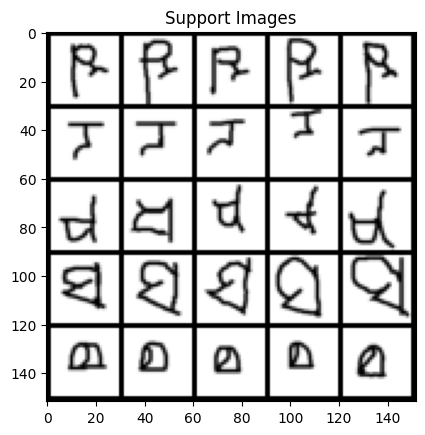

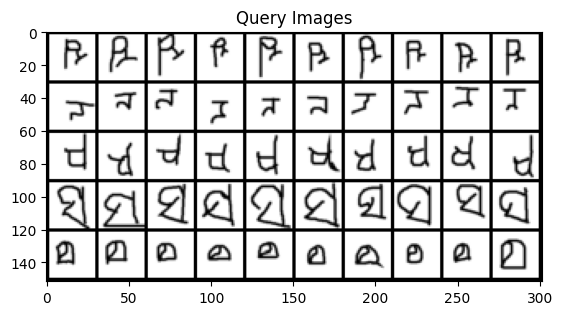

In [14]:
#e-example
#s-support
#q-query
#i-images
#l-labels
#c-class
#id
(e_s_i,e_s_l,e_q_i,e_q_l,e_c_id)=next(iter(test_loader))
# print(next(iter(test_loader))[3])
plot_images(e_s_i,"Support Images",images_per_row=N_SHOT)
plot_images(e_q_i,"Query Images",images_per_row=N_QUERY)

In [15]:
model.eval()
e_score=model(e_s_i.to(device),e_s_l.to(device),e_q_i.to(device)).detach()

_,e_pred_l=torch.max(e_score.data,1)

print("Truth / Pred")
for i in range(len(e_q_l)):
  print(f"{test_set._characters[e_c_id[e_q_l[i]]]} / {test_set._characters[e_c_id[e_pred_l[i]]]}")

Truth / Pred
Tibetan/character37 / Tibetan/character37
Tibetan/character37 / Tibetan/character37
Tibetan/character37 / Tengwar/character03
Tibetan/character37 / Tibetan/character37
Tibetan/character37 / Tibetan/character37
Tibetan/character37 / Tibetan/character37
Tibetan/character37 / Tibetan/character37
Tibetan/character37 / Tibetan/character37
Tibetan/character37 / Tibetan/character37
Tibetan/character37 / Tibetan/character37
Mongolian/character16 / Mongolian/character16
Mongolian/character16 / Mongolian/character16
Mongolian/character16 / Mongolian/character16
Mongolian/character16 / Mongolian/character16
Mongolian/character16 / Mongolian/character16
Mongolian/character16 / Mongolian/character16
Mongolian/character16 / Tengwar/character03
Mongolian/character16 / Mongolian/character16
Mongolian/character16 / Mongolian/character16
Mongolian/character16 / Mongolian/character16
Tengwar/character03 / Tibetan/character37
Tengwar/character03 / Tengwar/character03
Tengwar/character03 / Mon

In [16]:
def eval_one_task(s_i,s_l,q_i,q_l):
  return (torch.max(model(s_i.to(device),s_l.to(device),q_i.to(device)).detach().data,1)[1]==q_l.to(device)).sum().item(),len(q_l)

In [17]:
def evaluate(loader):
  model.eval()
  with torch.no_grad():
    total_pred=0
    correct_pred=0
    for s_i,s_l,q_i,q_l,c_id in tqdm(loader):
      c,t=eval_one_task(s_i,s_l,q_i,q_l)
      total_pred+=t
      correct_pred+=c
  print(f"Model is tested on {len(loader)} tasks and got Accuracy:{100*correct_pred/total_pred}")


In [18]:
evaluate(test_loader)

100%|██████████| 100/100 [00:06<00:00, 15.66it/s]

Model is tested on 100 tasks and got Accuracy:86.96


# Training

In [19]:
N_WAY=5
N_SHOT=5
N_QUERY=10


train_eps=40000
val_tasks=100

train_set.get_labels=lambda: [i[1] for i in train_set._flat_character_images]

train_sampler=TaskSampler(train_set,n_way=N_WAY,n_shot=N_SHOT,n_query=N_QUERY,n_tasks=train_eps)

train_loader=DataLoader(train_set,batch_sampler=train_sampler,num_workers=12,pin_memory=True,collate_fn=train_sampler.episodic_collate_fn)

In [20]:
print(sum(p.numel() for p in model.parameters()))

11176512


In [21]:
crit=nn.CrossEntropyLoss()
opt=optim.AdamW(model.parameters(),lr=1e-3)

In [22]:
def fit(s_i,s_l,q_i,q_l):
  classification_score=model(s_i.to(device),s_l.to(device),q_i.to(device))
  loss=crit(classification_score,q_l.to(device))
  opt.zero_grad()
  loss.backward()
  opt.step()

  return loss.item()


In [24]:
all_loss=[]
model.train()
with tqdm(enumerate(train_loader),total=len(train_loader)) as tqdm_train:
  for i,(s_i,s_l,q_i,q_l,c_id) in tqdm_train:
    loss_val=fit(s_i,s_l,q_i,q_l)
    all_loss.append(loss_val)

    if i%10==0:
      tqdm_train.set_postfix(loss=sliding_average(all_loss,10))

100%|██████████| 40000/40000 [44:33<00:00, 14.96it/s, loss=0.24]


In [29]:
evaluate(test_loader)

100%|██████████| 100/100 [00:04<00:00, 22.25it/s]

Model is tested on 100 tasks and got Accuracy:97.64


In [26]:
path="FSL-prototypical.pth"

In [27]:
torch.save(model.state_dict(), path)

In [28]:
model.load_state_dict(torch.load(path))

<All keys matched successfully>

# Omniglot Check

In [97]:
image_size = 28


train_set = Omniglot(
    root="./data",
    background=True,
    transform=transforms.Compose(
        [
            transforms.Grayscale(num_output_channels=3),
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)
test_set = Omniglot(
    root="./data",
    background=False,
    transform=transforms.Compose(
        [

            transforms.Grayscale(num_output_channels=3),
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)


In [98]:
N_WAY=5
N_SHOT=5
N_QUERY=10
N_TASK=100

test_set.get_labels=lambda:[i[1] for i in test_set._flat_character_images]
task_sampler=TaskSampler(test_set,n_way=N_WAY,n_shot=N_SHOT,n_query=N_QUERY,n_tasks=N_TASK)

test_loader=DataLoader(test_set,batch_sampler=task_sampler,num_workers=12,collate_fn=task_sampler.episodic_collate_fn,pin_memory=True)

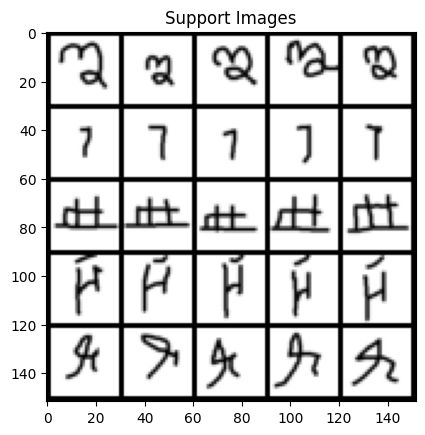

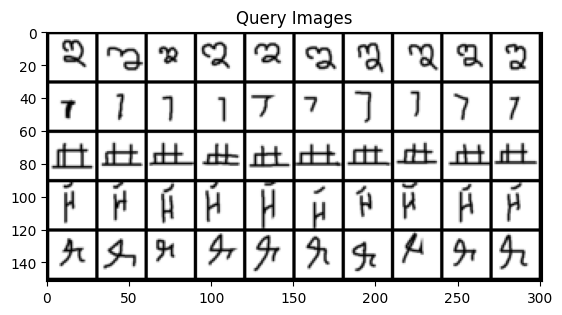

In [99]:
#e-example
#s-support
#q-query
#i-images
#l-labels
#c-class
#id
(e_s_i,e_s_l,e_q_i,e_q_l,e_c_id)=next(iter(test_loader))
# print(next(iter(test_loader))[3])
plot_images(e_s_i,"Support Images",images_per_row=N_SHOT)
plot_images(e_q_i,"Query Images",images_per_row=N_QUERY)

In [100]:
evaluate(test_loader)

100%|██████████| 100/100 [00:04<00:00, 22.56it/s]

Model is tested on 100 tasks and got Accuracy:97.42


# MNIST Check

In [101]:
image_size = 28


train_set = MNIST(
    root="./data",
    train=True,
    transform=transforms.Compose(
        [
            transforms.Lambda(lambda x: transforms.functional.invert(x)),
            transforms.Grayscale(num_output_channels=3),
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)
test_set = MNIST(
    root="./data",
    train=False,
    transform=transforms.Compose(
        [
            transforms.Lambda(lambda x: transforms.functional.invert(x)),
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)


In [102]:
N_WAY=5
N_SHOT=5
N_QUERY=10
N_TASK=100

test_set.get_labels=lambda:test_set.targets.tolist()
task_sampler=TaskSampler(test_set,n_way=N_WAY,n_shot=N_SHOT,n_query=N_QUERY,n_tasks=N_TASK)

test_loader=DataLoader(test_set,batch_sampler=task_sampler,num_workers=12,collate_fn=task_sampler.episodic_collate_fn,pin_memory=True)

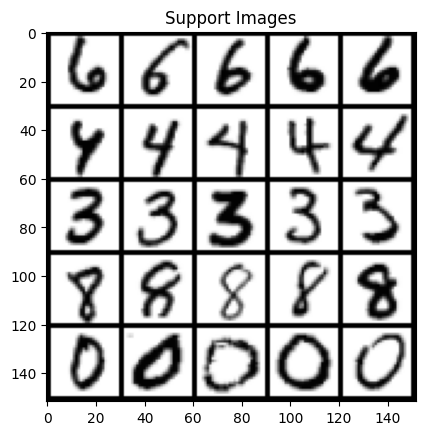

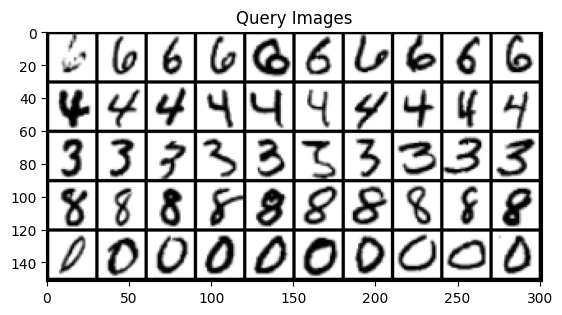

In [103]:
# #e-example
# #s-support
# #q-query
# #i-images
# #l-labels
# #c-class
# #id
(e_s_i,e_s_l,e_q_i,e_q_l,e_c_id)=next(iter(test_loader))
# print(next(iter(test_loader))[3])
plot_images(e_s_i,"Support Images",images_per_row=N_SHOT)
plot_images(e_q_i,"Query Images",images_per_row=N_QUERY)

In [104]:
model.eval()
e_score=model(e_s_i.to(device),e_s_l.to(device),e_q_i.to(device)).detach()

_,e_pred_l=torch.max(e_score.data,1)

print("Truth / Pred")
for i in range(len(e_q_l)):
  print(f"{test_set.targets.tolist()[e_c_id[e_q_l[i]]]} / {test_set.targets.tolist()[e_c_id[e_pred_l[i]]]}")

Truth / Pred
4 / 0
4 / 4
4 / 4
4 / 4
4 / 4
4 / 4
4 / 7
4 / 4
4 / 4
4 / 4
4 / 4
4 / 4
4 / 4
4 / 4
4 / 4
4 / 4
4 / 4
4 / 4
4 / 4
4 / 4
0 / 5
0 / 0
0 / 5
0 / 0
0 / 0
0 / 5
0 / 0
0 / 0
0 / 0
0 / 0
5 / 5
5 / 0
5 / 4
5 / 4
5 / 5
5 / 5
5 / 4
5 / 5
5 / 4
5 / 5
7 / 5
7 / 7
7 / 7
7 / 7
7 / 7
7 / 7
7 / 7
7 / 7
7 / 7
7 / 7


In [105]:
evaluate(test_loader)

100%|██████████| 100/100 [00:03<00:00, 28.56it/s]

Model is tested on 100 tasks and got Accuracy:84.44


# FMNIST Check

In [106]:
from torchvision.datasets import FashionMNIST

In [107]:
image_size = 28


train_set = FashionMNIST(
    root="./data",
    train=True,
    transform=transforms.Compose(
        [
            transforms.Lambda(lambda x: transforms.functional.invert(x)),
            transforms.Grayscale(num_output_channels=3),
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)
test_set = FashionMNIST(
    root="./data",
    train=False,
    transform=transforms.Compose(
        [
            transforms.Lambda(lambda x: transforms.functional.invert(x)),
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)


In [108]:
N_WAY=5
N_SHOT=5
N_QUERY=10
N_TASK=100

test_set.get_labels=lambda:test_set.targets.tolist()
task_sampler=TaskSampler(test_set,n_way=N_WAY,n_shot=N_SHOT,n_query=N_QUERY,n_tasks=N_TASK)

test_loader=DataLoader(test_set,batch_sampler=task_sampler,num_workers=12,collate_fn=task_sampler.episodic_collate_fn,pin_memory=True)

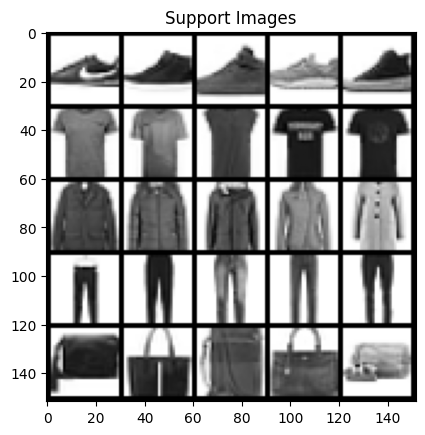

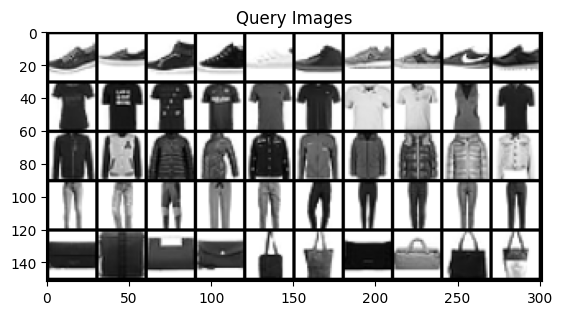

In [109]:
# #e-example
# #s-support
# #q-query
# #i-images
# #l-labels
# #c-class
# #id
(e_s_i,e_s_l,e_q_i,e_q_l,e_c_id)=next(iter(test_loader))
# print(next(iter(test_loader))[3])
plot_images(e_s_i,"Support Images",images_per_row=N_SHOT)
plot_images(e_q_i,"Query Images",images_per_row=N_QUERY)

In [110]:
model.eval()
e_score=model(e_s_i.to(device),e_s_l.to(device),e_q_i.to(device)).detach()

_,e_pred_l=torch.max(e_score.data,1)

print("Truth / Pred")
for i in range(len(e_q_l)):
  print(f"{test_set.targets.tolist()[e_c_id[e_q_l[i]]]} / {test_set.targets.tolist()[e_c_id[e_pred_l[i]]]}")

Truth / Pred
6 / 6
6 / 6
6 / 6
6 / 6
6 / 6
6 / 6
6 / 6
6 / 6
6 / 6
6 / 6
9 / 9
9 / 9
9 / 9
9 / 9
9 / 9
9 / 9
9 / 5
9 / 5
9 / 9
9 / 9
6 / 9
6 / 2
6 / 6
6 / 6
6 / 9
6 / 6
6 / 6
6 / 9
6 / 6
6 / 5
2 / 2
2 / 2
2 / 2
2 / 2
2 / 2
2 / 2
2 / 2
2 / 2
2 / 2
2 / 2
5 / 5
5 / 5
5 / 5
5 / 5
5 / 9
5 / 9
5 / 5
5 / 6
5 / 5
5 / 5


In [111]:
evaluate(test_loader)

100%|██████████| 100/100 [00:03<00:00, 28.34it/s]

Model is tested on 100 tasks and got Accuracy:62.14


# KNIST Check

In [112]:
from torchvision.datasets import KMNIST

In [113]:
image_size = 28


train_set = KMNIST(
    root="./data",
    train=True,
    transform=transforms.Compose(
        [
            transforms.Lambda(lambda x: transforms.functional.invert(x)),
            transforms.Grayscale(num_output_channels=3),
            transforms.RandomResizedCrop(image_size),
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)
test_set = KMNIST(
    root="./data",
    train=False,
    transform=transforms.Compose(
        [
            transforms.Lambda(lambda x: transforms.functional.invert(x)),
            transforms.Grayscale(num_output_channels=3),
            transforms.Resize([int(image_size * 1.15), int(image_size * 1.15)]),
            transforms.CenterCrop(image_size),
            transforms.ToTensor(),
        ]
    ),
    download=True,
)


In [114]:
N_WAY=5
N_SHOT=5
N_QUERY=10
N_TASK=100

test_set.get_labels=lambda:test_set.targets.tolist()
task_sampler=TaskSampler(test_set,n_way=N_WAY,n_shot=N_SHOT,n_query=N_QUERY,n_tasks=N_TASK)

test_loader=DataLoader(test_set,batch_sampler=task_sampler,num_workers=12,collate_fn=task_sampler.episodic_collate_fn,pin_memory=True)

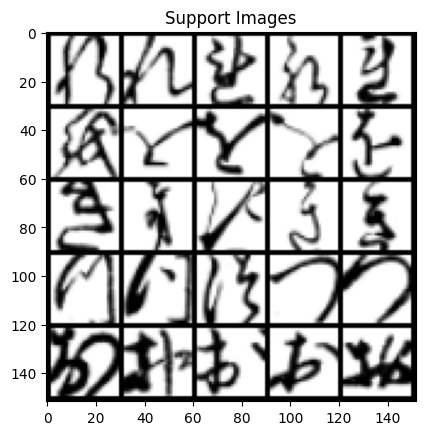

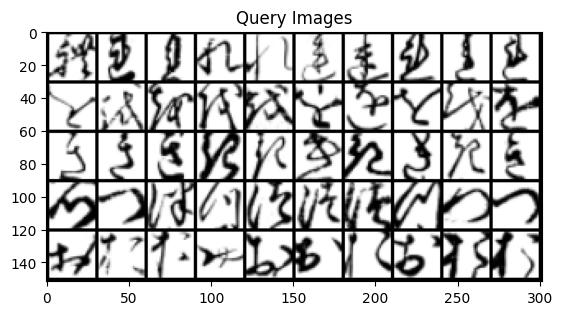

In [115]:
# #e-example
# #s-support
# #q-query
# #i-images
# #l-labels
# #c-class
# #id
(e_s_i,e_s_l,e_q_i,e_q_l,e_c_id)=next(iter(test_loader))
# print(next(iter(test_loader))[3])
plot_images(e_s_i,"Support Images",images_per_row=N_SHOT)
plot_images(e_q_i,"Query Images",images_per_row=N_QUERY)

In [116]:
model.eval()
e_score=model(e_s_i.to(device),e_s_l.to(device),e_q_i.to(device)).detach()

_,e_pred_l=torch.max(e_score.data,1)

print("Truth / Pred")
for i in range(len(e_q_l)):
  print(f"{test_set.targets.tolist()[e_c_id[e_q_l[i]]]} / {test_set.targets.tolist()[e_c_id[e_pred_l[i]]]}")

Truth / Pred
2 / 2
2 / 9
2 / 2
2 / 8
2 / 8
2 / 9
2 / 9
2 / 2
2 / 9
2 / 9
5 / 5
5 / 2
5 / 2
5 / 2
5 / 2
5 / 5
5 / 2
5 / 5
5 / 2
5 / 2
9 / 9
9 / 9
9 / 9
9 / 2
9 / 8
9 / 5
9 / 2
9 / 9
9 / 8
9 / 9
8 / 2
8 / 5
8 / 2
8 / 8
8 / 2
8 / 2
8 / 2
8 / 8
8 / 5
8 / 8
2 / 2
2 / 5
2 / 2
2 / 5
2 / 5
2 / 2
2 / 8
2 / 2
2 / 2
2 / 2


In [117]:
evaluate(test_loader)

100%|██████████| 100/100 [00:03<00:00, 28.08it/s]

Model is tested on 100 tasks and got Accuracy:50.02
